In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from scipy import ndimage
import glob

from skimage import io, img_as_float
from skimage.feature import canny
from skimage.filters import threshold_otsu, threshold_adaptive, gaussian_filter, sobel
from skimage.morphology import closing, square
from scipy import ndimage as ndi
from skimage.morphology import watershed, skeletonize, disk
from skimage.color import label2rgb, rgb2grey
from skimage.transform import resize
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops

from skimage.filters.rank import median
from skimage.util import pad, crop
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

In [2]:
%matplotlib inline
#im = io.imread('English/Img/GoodImg/Bmp/Sample029/img029-00030.png', as_grey = True)
io.imshow(im)

NameError: name 'im' is not defined

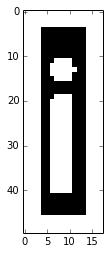

In [13]:
def binarize(im):
    height, width = im.shape
    avg = np.mean([im[0,0], im[height-1,0], im[0, width-1], im[height-1,width-1]])
    if avg > 0.5:
        pads = 1
    else:
        pads = 0
    gaussian = gaussian_filter(im, sigma = 1)
    binary = threshold_adaptive(gaussian, 100, 'mean')
    padded = pad(binary, (4,4), 'constant', constant_values=(1,1))
    return padded
binary = binarize(im)
io.imshow(binary)

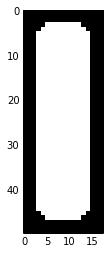

In [14]:
def edge_fill(padded):
    edges = canny(padded, sigma=.1)
    fill = ndi.binary_fill_holes(edges)
    return fill
fill = edge_fill(binary)
io.imshow(fill)

In [15]:
def load_images(filepath):
    files = glob.glob(filepath)
    images = []
    total = 0
    for f in files:
        image = np.load(f)
        images.append(image)
        total += 1
        if total >= 50:
            break
    return images

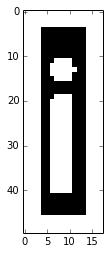

In [16]:
def clean_image(padded, fill):
    if padded[0,0] == True:
        inside = np.logical_and(padded, fill)
        outline = np.logical_xor(inside, fill)
    else:
         outline = np.logical_and(padded, fill)
    clean = np.logical_not(outline)
    return clean
clean = clean_image(binary, fill)  
io.imshow(clean)

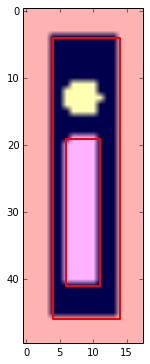

In [17]:
#label image regions
label_image = label(clean)
image_label_overlay = label2rgb(label_image, image=clean)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(image_label_overlay)

imarea = im.shape[0] * im.shape[1]

for region in regionprops(label_image):

    # skip small images
    if region.area < imarea/6:
        continue

    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.show()

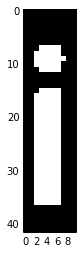

In [18]:
def bbox_crop(clean):
    label_image = label(clean)
    imarea = im.shape[0] * im.shape[1]

    for region in regionprops(label_image):
        # skip small images
        if region.area < imarea/6:
            continue

        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        cropped = clean[minr:maxr,minc:maxc]
        return cropped
cropped = bbox_crop(clean)
io.imshow(cropped)

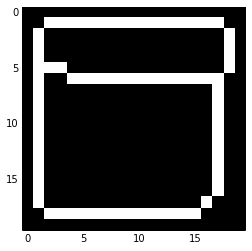

In [19]:
def skeleton_resize(cropped):
    resized = resize(cropped, (20,20))
    rev = np.logical_not(resized)
    skel = skeletonize(rev)
    return skel
skel = skeleton_resize(cropped)
io.imshow(skel)

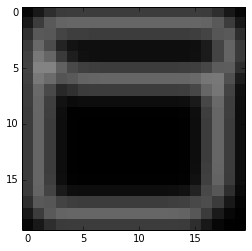

In [27]:
gaussian = gaussian_filter(skel, sigma=1)
io.imshow(gaussian)

In [11]:
def preprocess(im):
    binary = binarize(im)
    fill = edge_fill(binary)
    clean = clean_image(binary, fill)
    cropped = bbox_crop(clean)
    skel = skeleton_resize(cropped)
    return skel

image = preprocess(im)
io.imshow(image)    

NameError: name 'im' is not defined

In [11]:
def process_images(filepath, fdir):
    images = load_images(filepath)
    imnum = 1
    errors = []
    for image in images:
        try:
            im = preprocess(image)
            path =  fdir + str(imnum)
            np.save(path,im)
        except AttributeError:
            errors.append(imnum)
        imnum += 1
    print errors

In [845]:
#process_images("English/Img/GoodImg/Bmp/Sample010/*.png", "images/class9/sample")

[28]


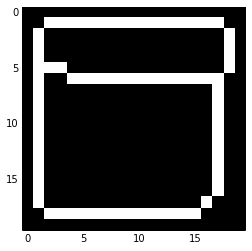

In [12]:
im = io.imread('English/Img/GoodImg/Bmp/Sample045/img045-00050.png', as_grey = True)
image = preprocess(im)
io.imshow(image)

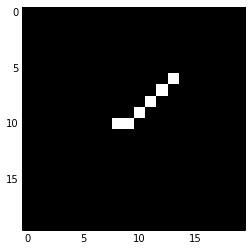

In [1173]:
path = "images/class44/sample050.npy"
loaded = np.load(path)
io.imshow(loaded)

In [1183]:
np.save(path, image)

In [28]:
dirlist = glob.glob("blurred_images2/*")
for dr in dirlist:
    f = glob.glob(dr + "/*.npy")
    for path in f:
        image = np.load(path)
        gaussian = gaussian_filter(image, sigma=1)
        np.save(path, gaussian)

In [29]:
def display_image(n):
    io.imshow(image[n])

In [30]:
image = load_images("blurred_images2/class01/*.npy")
len(image)

50

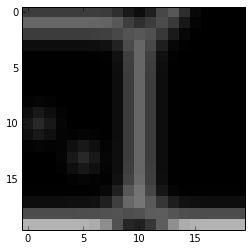

In [31]:
interact(display_image, n=(0,len(image)-1))